# Import Libiraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pickle
# plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

In [3]:
# Import QREM package
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_31077/4110962823.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [4]:
# Import mitiq for zne
import mitiq

In [5]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [6]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Trotter Gate

In [7]:
def trotter_gate(dt, to_instruction = True):
    qc = QuantumCircuit(2)
    qc.rx(2*dt,0)
    qc.rz(2*dt,1)
    qc.h(1)
    qc.cx(1,0)
    qc.rz(-2*dt, 0)
    qc.rx(-2*dt, 1)
    qc.rz(2*dt, 1)
    qc.cx(1,0)
    qc.h(1)
    qc.rz(2*dt, 0)
    return qc.to_instruction() if to_instruction else qc

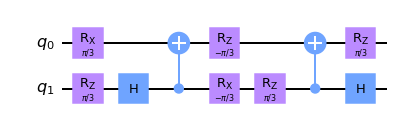

In [8]:
trotter_gate(np.pi / 6, to_instruction=False).draw("mpl")

# Set Parameters

In [9]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

# The final time of the state evolution
target_time = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')
# Convert custom quantum circuit into a gate
Trot_gate = trotter_gate(dt)

# Number of trotter steps
trotter_steps = 50  ### CAN BE >= 4

# Make Quantum Circuit

In [10]:
# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, [qr[3], qr[5]])

qc.cx(qr[3], qr[1])
qc.cx(qr[5], qr[3])

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({dt: target_time/trotter_steps})
t3_qc = transpile(qc, optimization_level=3, basis_gates=["sx", "cx", "rz"])
t3_qc = transpile(t3_qc, optimization_level=3, basis_gates=["sx", "cx", "rz"])

In [11]:
# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(t3_qc, [qr[1], qr[3], qr[5]])

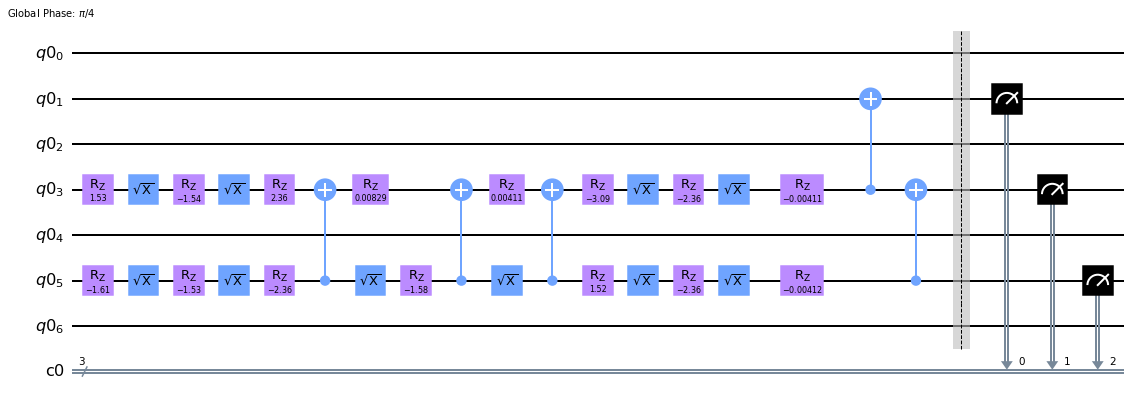

In [12]:
# Display circuit for confirmation
# st_qcs[-1].decompose().draw()  # view decomposition of trotter gates
st_qcs[-1].draw("mpl")  # only view trotter gates

# Set Backend

In [13]:
# from qiskit.test.mock import FakeJakarta
# backend = FakeJakarta()
# backend = Aer.get_backend("qasm_simulator")

IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
print("provider:", provider)
backend = provider.get_backend("ibmq_jakarta")

provider: <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')>


# Set Execute Options

In [14]:
shots = 8192
reps = 8

In [15]:
jobs = []
for _ in range(reps):
    # execute
    job = execute(st_qcs, backend, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 6254531ad8e31a637c8b4927
Job ID 6254531d9def4236f7a985ec
Job ID 6254531fde7fc63be5c20ab8
Job ID 62545320d66fd63b64a94471
Job ID 62545322d7294b7d769f0f6e
Job ID 625453243bfc76bb04eac014
Job ID 62545326d66fd6e959a94472
Job ID 62545327434999e278770ae0


# QREM

In [16]:
# QREM
qr = QuantumRegister(num_qubits)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
cal_job = execute(meas_calibs, backend=backend, shots=shots, optimization_level=3, initial_layout=[5,3,1])
print('Job ID', cal_job.job_id())

Job ID 625453289def427fd9a985ed


In [17]:
dt_now = datetime.datetime.now()

In [21]:
print(dt_now)

2022-04-12 01:11:21.461513


In [18]:
with open("jobs_jakarta_50step_" + dt_now.strftime('%Y%m%d_%H%M%S') + "_.pkl", "wb") as f:
    pickle.dump({"jobs": jobs, "cal_job": cal_job}, f)

In [19]:
with open("job_ids_jakarta_50step_" + dt_now.strftime('%Y%m%d_%H%M%S') + "_.pkl", "wb") as f:
    pickle.dump({"job_ids": [job.job_id() for job in jobs], "cal_job_id": cal_job.job_id()}, f)

In [20]:
with open("properties_jakarta" + dt_now.strftime('%Y%m%d_%H%M%S') + "_.pkl", "wb") as f:
    pickle.dump(backend.properties(), f)

# ====== wait for the job ======

In [16]:
with open("jakarta_50step.pkl", "rb") as f:
    job_list = pickle.load(f)

In [17]:
jobs = job_list["jobs"]
cal_job = job_list["cal_job"]

In [20]:
cal_results = cal_job.result()
print("retrieved cal_results")
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
mit_results = []
for i, job in enumerate(jobs):
    mit_results.append( meas_fitter.filter.apply(job.result()) )
    print("retrieved", i, "th results")

KeyboardInterrupt: 

# State Tomography

In [18]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute Fidelity

In [19]:
# Compute tomography fidelities for each repetition
fids = []
for result in mit_results:
    fid = state_tomo(result, st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.9008 ± 0.0022
